In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import glob
# 데이터 전처리 후 시각화에 도움을 주는 라이브러리
import missingno as msno

from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion, make_union
import imblearn
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
import os
from bayes_opt import BayesianOptimization
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

import tensorflow as tf
from scipy.stats import chi2_contingency, ttest_ind
import category_encoders as CE

for dirname, _, filenames in os.walk('../kaggle/MLproject_dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../kaggle/MLproject_dataset\cell2cellholdout.csv
../kaggle/MLproject_dataset\cell2celltrain.csv


In [2]:
df = pd.read_csv('../kaggle/MLproject_dataset/cell2celltrain.csv', index_col='CustomerID')
df_test = pd.read_csv('../kaggle/MLproject_dataset/cell2cellholdout.csv', index_col='CustomerID')
print(df.shape)
df

(51047, 57)


,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,6.3,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.0,0.3,61,2,1,SEAPOR503,2.0,2.0,361.0,62.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,1,0,No,No,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,0.0,2.7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,0.0,58,1,1,PITHOM412,2.0,1.0,1504.0,40.0,42.0,Yes,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,Yes,No,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0.0,60,1,1,MILMIL414,1.0,1.0,1812.0,26.0,26.0,Yes,No,No,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,7.7,76.0,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,0.0,22.7,59,2,2,PITHOM412,9.0,4.0,458.0,30.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,Yes,No,0,6,No,0,10,No,4-Medium,Other,Other,No
3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,2,2,OKCTUL918,4.0,3.0,852.0,46.0,54.0,No,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,Yes,0,9,No,1,10,No,1-Highest,Other,Professional,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399958,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.3,2.7,48.3,0.0,0.0,58.9,17.0,1.3,160.3,33.3,12.0,0.0,0.3,29,1,1,LAXSFN818,2.0,2.0,526.0,68.0,64.0,No,Yes,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,No,No,0,6,No,0,60,No,1-Highest,Suburban,Other,Yes
3399974,No,95.17,1745.0,85.0,0.99,45.0,4.7,122.0,15.9,16.7,0.7,41.3,0.0,0.0,681.5,89.7,33.3,318.7,248.3,17.3,0.0,14.3,29,1,1,LAXCDG310,2.0,2.0,464.0,48.0,48.0,Yes,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,No,0,9,No,1,60,No,3-Good,Other,Other,No
3399978,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.7,4.3,287.0,1.3,13.7,1225.3,430.3,87.7,1359.0,910.3,76.0,0.0,6.7,25,1,1,LAXCDG310,3.0,2.0,378.0,36.0,0.0,No,No,Yes,No,No,Known,No,No,No,No,No,Yes,0,0,No,No,0,7,No,1,80,No,5-Low,Other,Clerical,No


In [3]:
# Unknown으로 들어간 데이터들이 있음. Unknown을 None(Null)으로 변경
# 신용등급은 숫자-평가 형태로 들어있음. 숫자로만 변경. 없으면 None 처리.
# HandsetPrice 데이터는 가짓수가 많은 것으로 보아 이산형 변수는 아닌거 같음. 연속형 변수로 형태 변환(float64)
def cleanup(df):
    df = df.replace('Unknown', np.nan)
    
    df['CreditRating'] = df['CreditRating'].apply(lambda x: int(x.split('-')[0]) if x else np.nan)
    df['HandsetPrice'] = df['HandsetPrice'].astype('float')
    return df

df = cleanup(df)
df_test = cleanup(df_test)
df.head().append(df.dtypes.rename('dtypes'))

C:\Users\User\AppData\Local\Temp\ipykernel_19824\1898202738.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.head().append(df.dtypes.rename('dtypes'))


,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3000002,Yes,24.0,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,6.3,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.0,0.3,61,2,1,SEAPOR503,2.0,2.0,361.0,62.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,1,0,No,No,0,4,No,0,30.0,Yes,1,Suburban,Professional,No
3000010,Yes,16.99,10.0,17.0,0.0,0.0,0.0,-4.0,0.0,0.3,0.0,2.7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,0.0,58,1,1,PITHOM412,2.0,1.0,1504.0,40.0,42.0,Yes,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,Yes,No,0,5,No,0,30.0,No,4,Suburban,Professional,Yes
3000014,No,38.0,8.0,38.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0.0,60,1,1,MILMIL414,1.0,1.0,1812.0,26.0,26.0,Yes,No,No,No,No,NaN,No,No,No,No,No,Yes,0,0,Yes,No,0,6,No,0,NaN,No,3,Town,Crafts,Yes
3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,7.7,76.0,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,0.0,22.7,59,2,2,PITHOM412,9.0,4.0,458.0,30.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,Yes,No,0,6,No,0,10.0,No,4,Other,Other,No
3000026,Yes,17.14,0.0,17.0,0.0,0.0,0.0,0.0,-0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,2,2,OKCTUL918,4.0,3.0,852.0,46.0,54.0,No,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,Yes,0,9,No,1,10.0,No,1,Other,Professional,Yes
dtypes,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,object,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,object,object,int64,int64,object,int64,float64,object,int64,object,object,object


In [4]:
# 컬럼 데이터타입 별 갯수 확인
df.dtypes.value_counts()

float64    27
object     21
int64       9
dtype: int64

<Axes: xlabel='Churn', ylabel='count'>

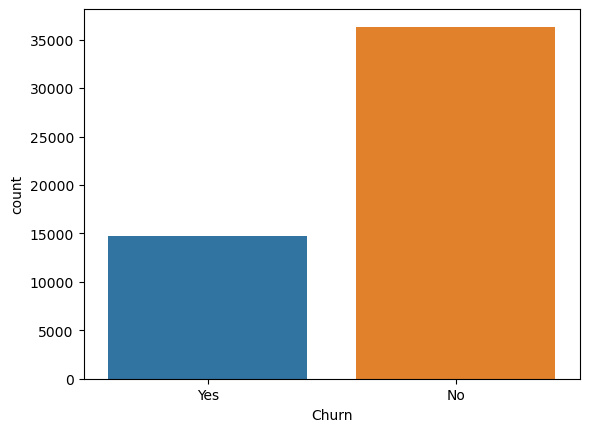

In [5]:
sns.countplot(x=df.Churn)

#### 이탈 여부 중 Yes는 약 30%, No는 약 70%임을 알 수 있음.
#### 데이터의 불균형이 심하므로, 모델을 학습할 때 imbalanced-learn 라이브러리를 사용하여 불균형을 해소해보려함.
#### 해당 라이브러리는 각 범주가 차지하는 비율을 조정하여 데이터를 샘플링해서 성능을 조절하는 라이브러리임.

## 각 컬럼별 상관여부 파악
### Numeric 데이터들의 분포 확인

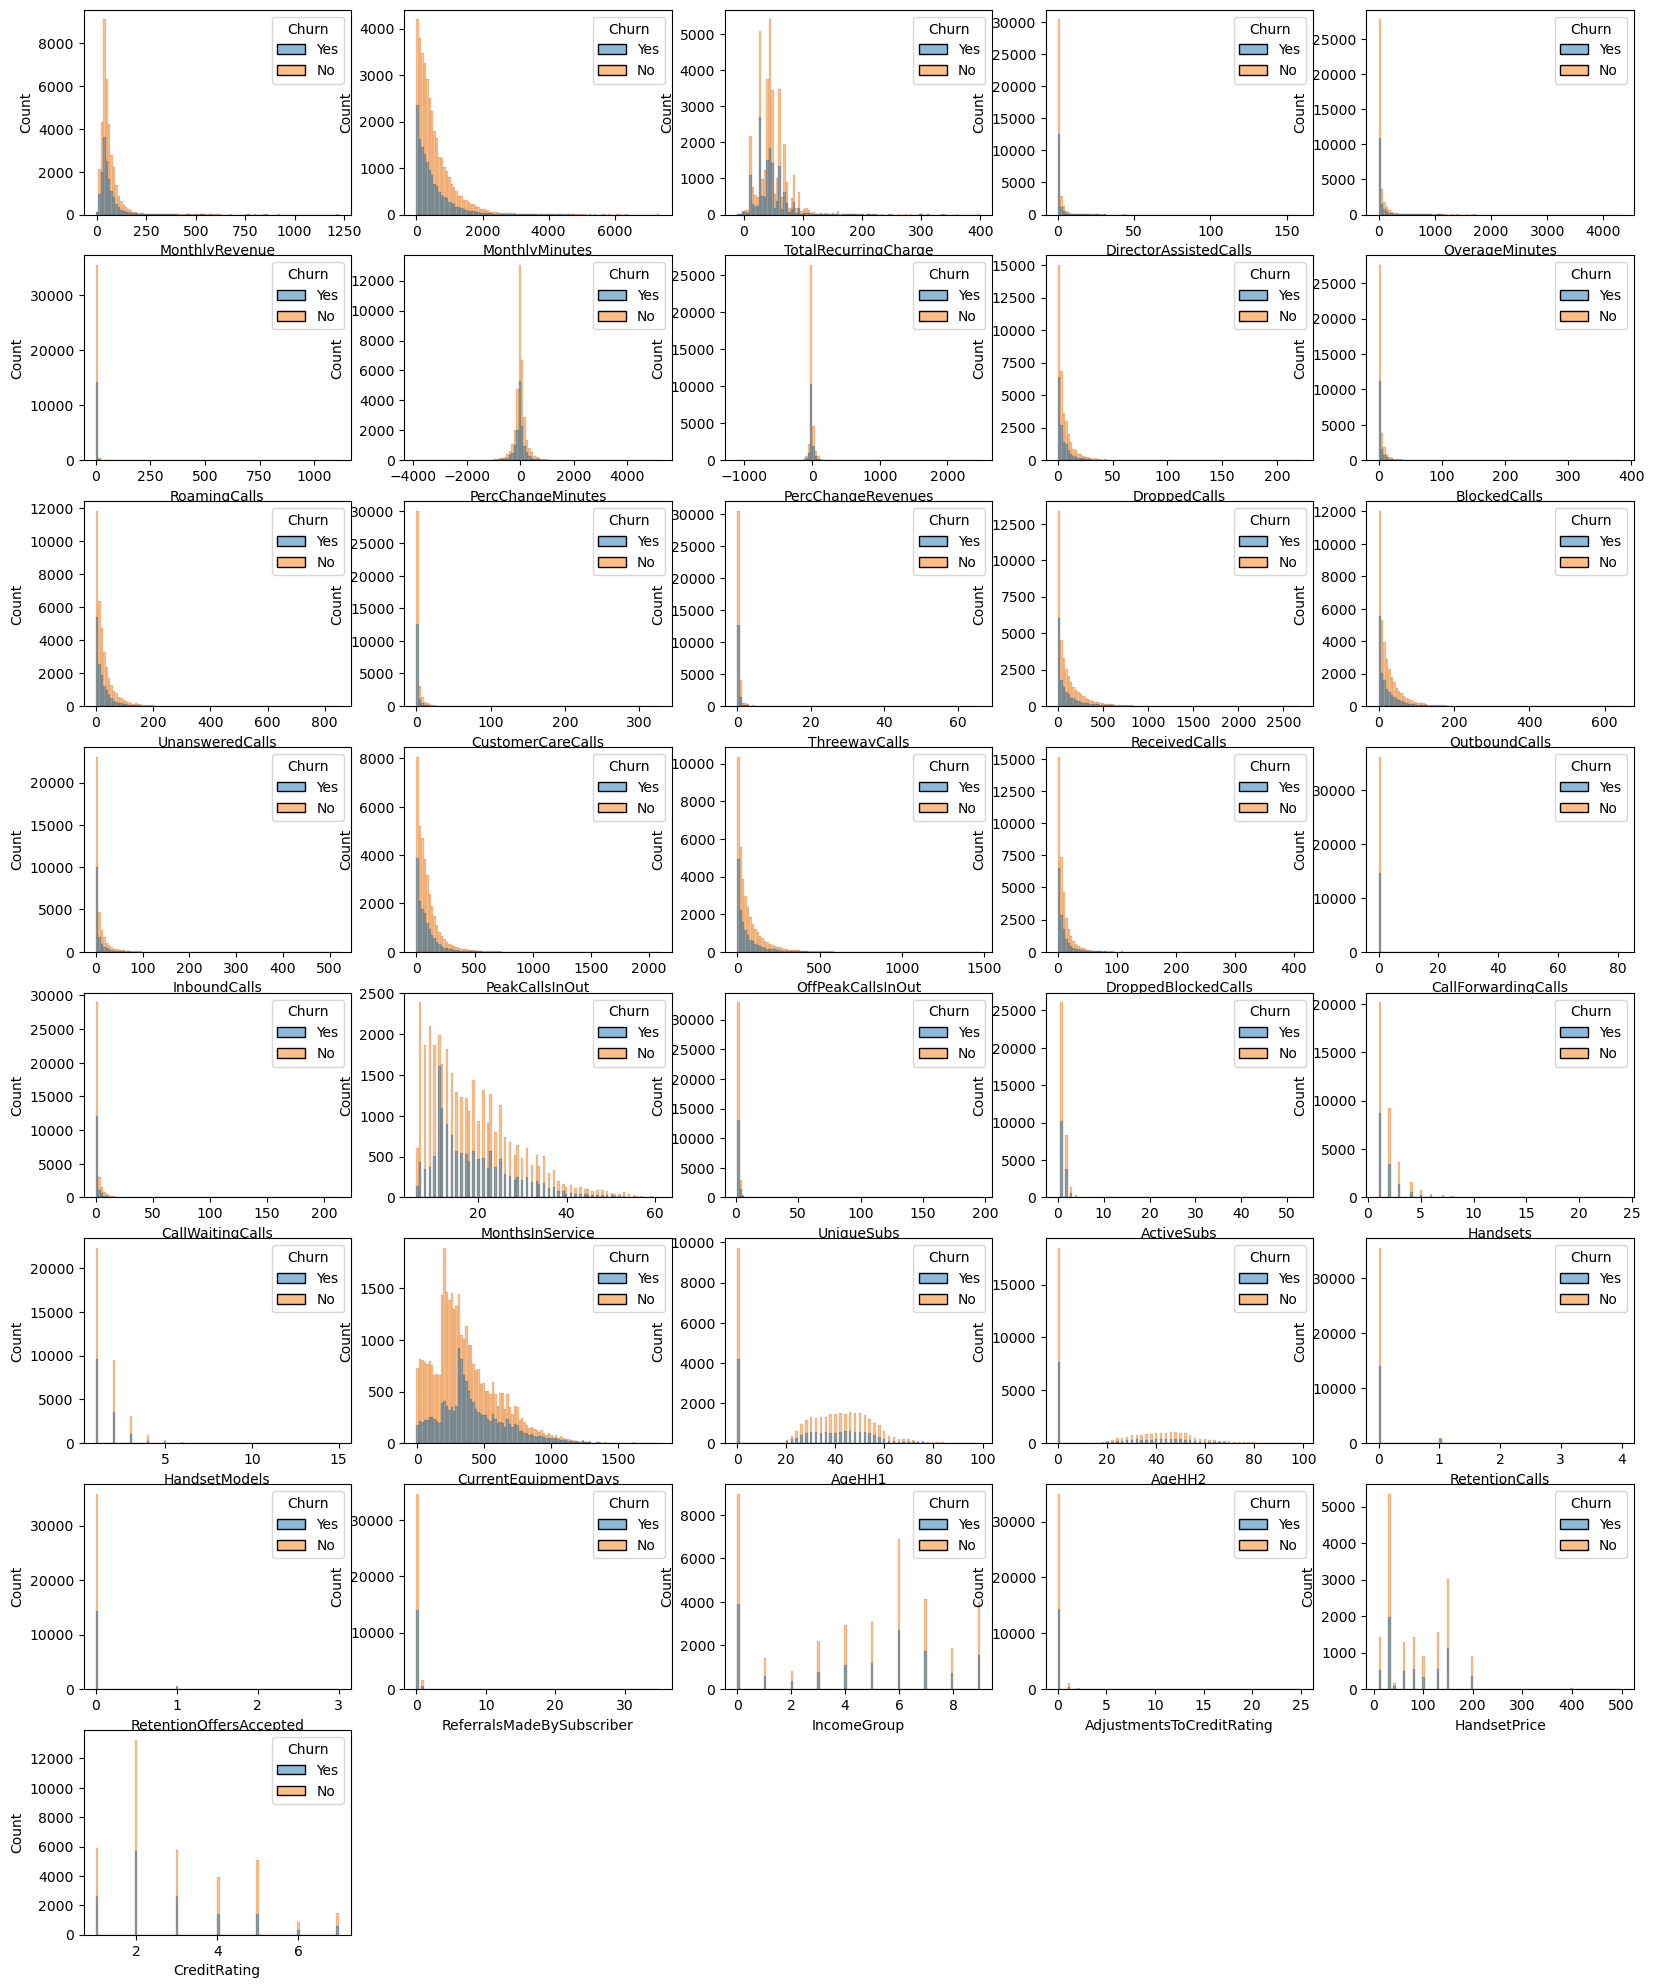

In [6]:
plots_per_row = 5

number_of_plots = df.select_dtypes(exclude=['object']).shape[-1]

fig, axes = plt.subplots((number_of_plots//plots_per_row) + (number_of_plots % 5 != 0), plots_per_row)

axes = axes.flatten()

count = 0
for index, col in df.select_dtypes(exclude=['object']).columns.to_series().items():
    a = sns.histplot(data=df, x=col, hue="Churn", ax=axes[count], kde=False, bins=100)
    count += 1
    
for i in range(1, len(axes) - number_of_plots + 1):
    fig.delaxes(axes[-i]) # 빈 subplot은 삭제
    
fig.set_figwidth(20)
fig.set_figheight(25)
plt.show()

### 이산형 데이터들의 분포 확인

In [7]:
# unique: 번호 가짓수
# top: 최빈 데이터
df.select_dtypes(include=['object']).describe()

,Churn,ServiceArea,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,NewCellphoneUser,NotNewCellphoneUser,OwnsMotorcycle,MadeCallToRetentionTeam,PrizmCode,Occupation,MaritalStatus
count,51047,51023,51047,51047,51047,51047,51047,33987,51047,51047,51047,51047,51047,51047,51047,51047,51047,51047,51047,51047,31347
unique,2,747,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,4,8,2
top,No,NYCBRO917,No,No,Yes,No,No,Known,No,No,No,No,No,Yes,No,No,No,No,Other,Other,Yes
freq,36336,1684,38679,43956,46046,41524,46894,33987,32596,31821,50295,48168,41583,34503,41223,44012,50368,49302,24655,37637,18651


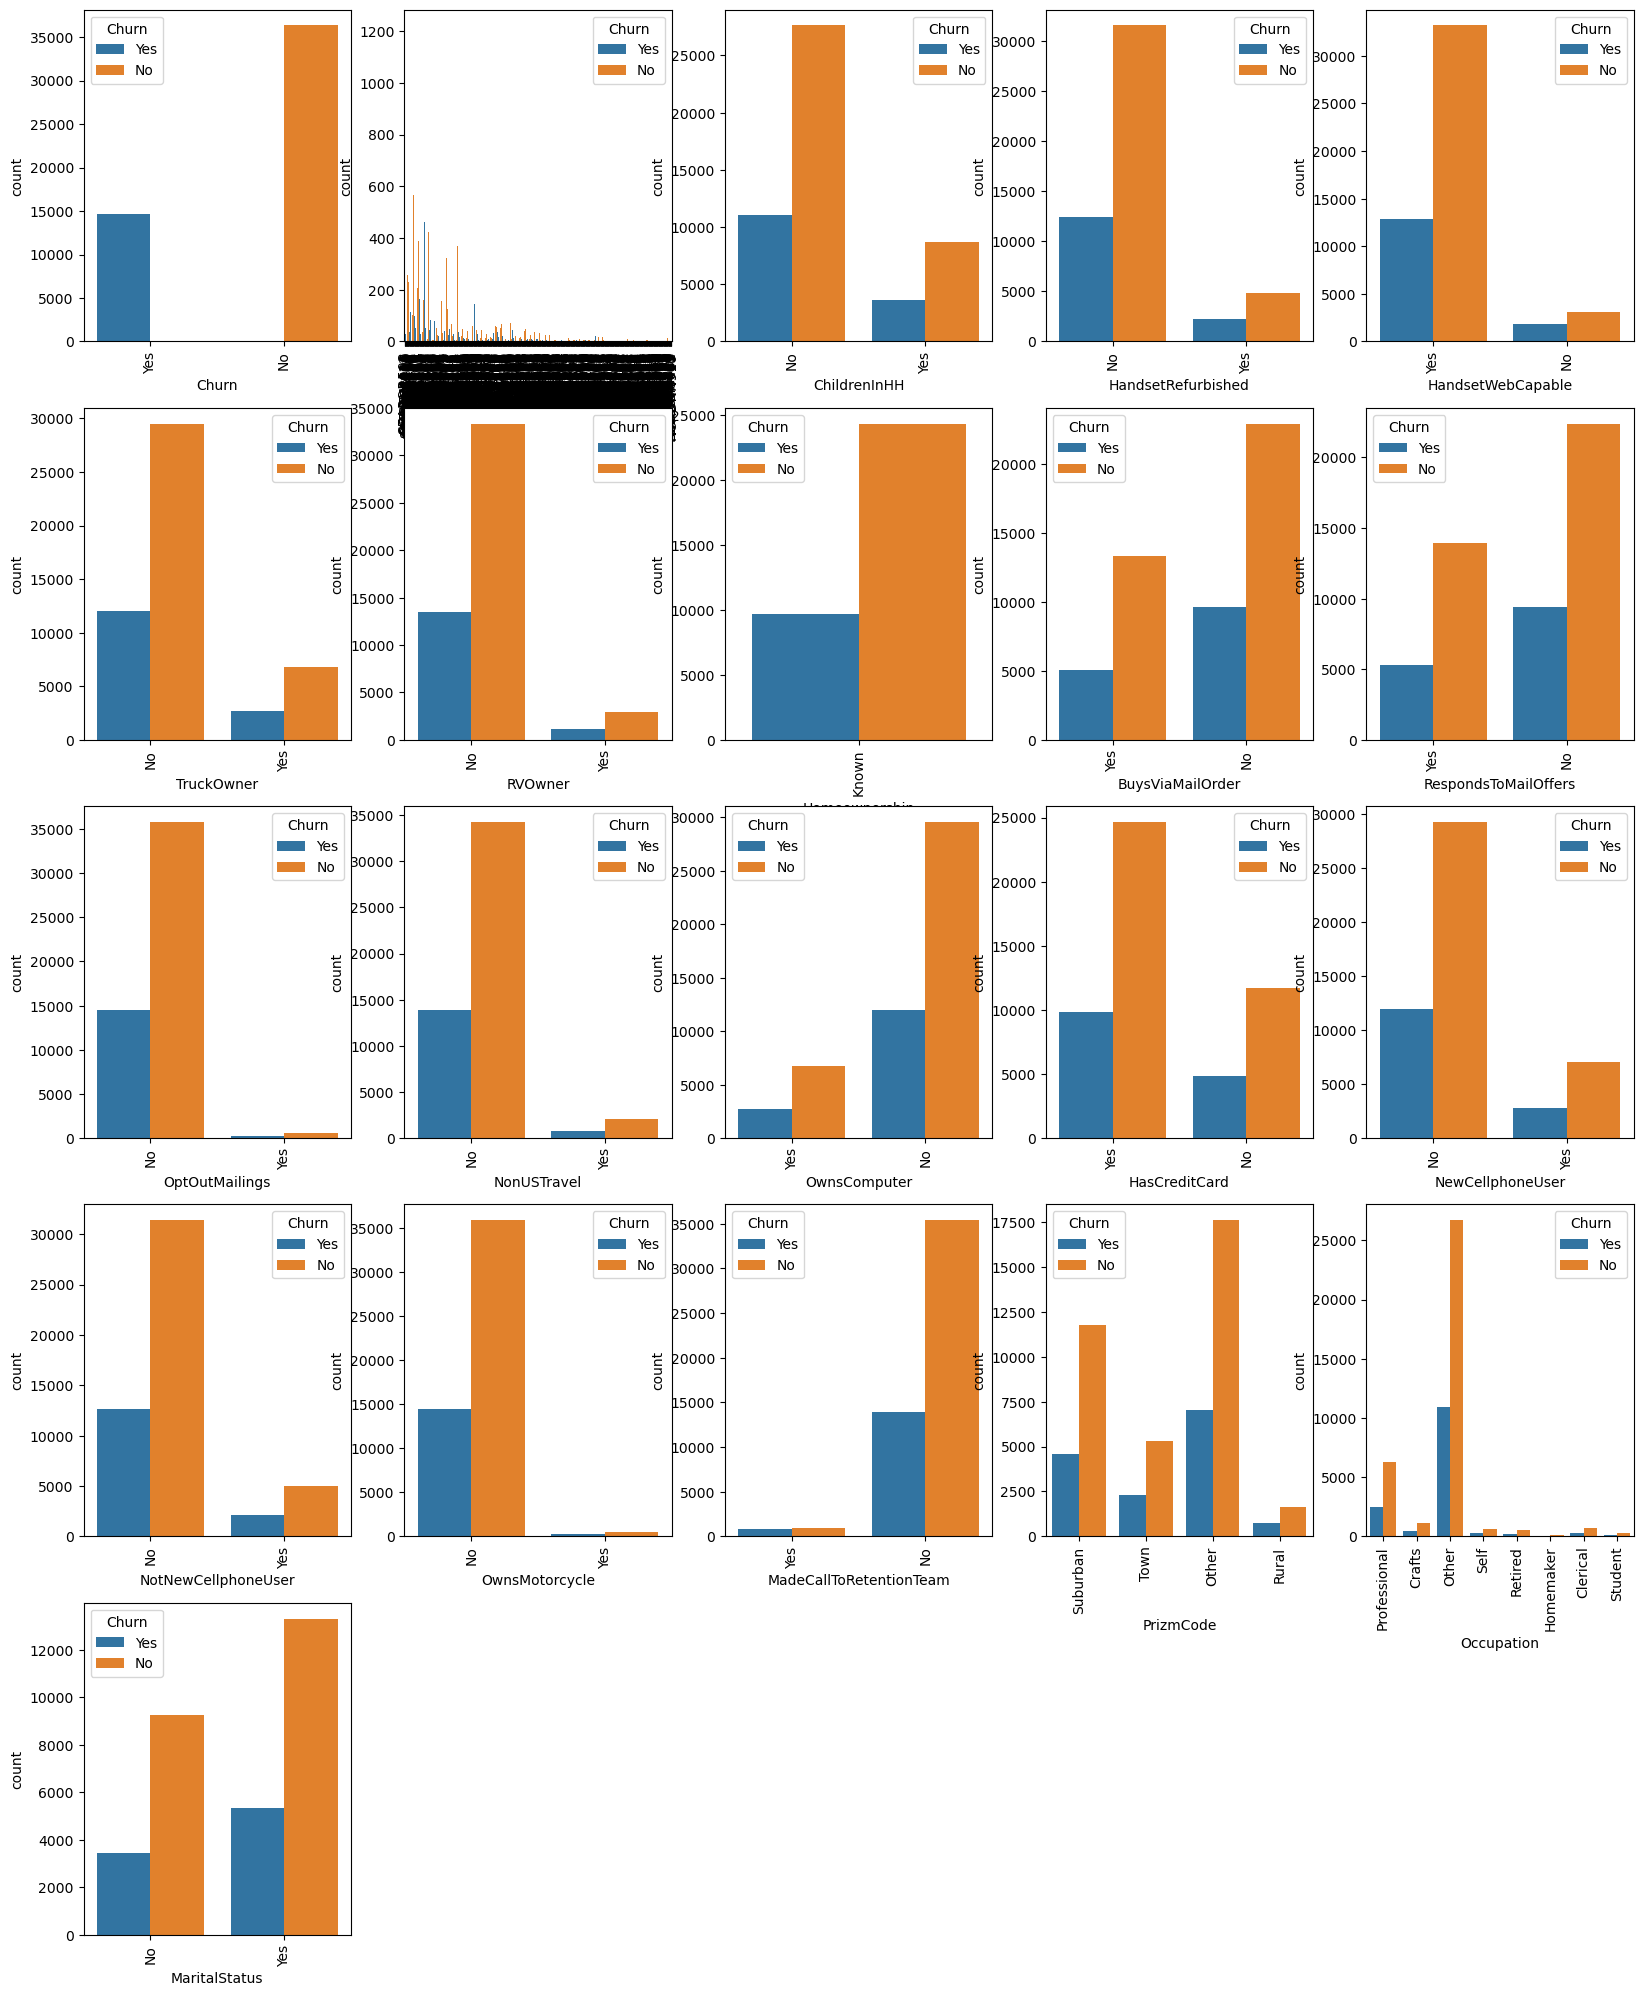

In [8]:
plots_per_row = 5

number_of_plots = df.select_dtypes(include=['object']).shape[-1]

fig, axes = plt.subplots((number_of_plots//plots_per_row) + (number_of_plots % 5 != 0), plots_per_row)

axes = axes.flatten()

count = 0
for index, col in df.select_dtypes(include=['object']).columns.to_series().items():
    a = sns.countplot(x=df[col], hue=df.Churn, ax=axes[count])
    a.tick_params(axis='x', labelrotation=90)
    count += 1
    
for i in range(1, len(axes) - number_of_plots + 1):
    fig.delaxes(axes[-i]) # 빈 subplot은 삭제
    
fig.set_figwidth(20)
fig.set_figheight(25)
plt.show()

In [9]:
# null(None) 값이 들어있는 데이터 각 컬럼별로 집계
null_rows_selector = df.isnull().any(axis=1)
null_row_count = df[null_rows_selector].shape[0]

df_null = df.isnull().groupby(df.Churn).sum().transpose()
df_null['total'] = df.isnull().sum()
df_null['percent'] = (df_null['total'] / len(df)) * 100
df_null = df_null[df_null.total != 0]

print("rows with null values: ", null_row_count, ", {:.2f}%".format((null_row_count / len(df) * 100)))
print('columns with null values: ', df_null.shape[0])

df_null

rows with null values:  39272 , 76.93%
columns with null values:  17


Churn,No,Yes,total,percent
MonthlyRevenue,86,70,156,0.305601
MonthlyMinutes,86,70,156,0.305601
TotalRecurringCharge,86,70,156,0.305601
DirectorAssistedCalls,86,70,156,0.305601
OverageMinutes,86,70,156,0.305601
RoamingCalls,86,70,156,0.305601
PercChangeMinutes,159,208,367,0.718945
PercChangeRevenues,159,208,367,0.718945
ServiceArea,12,12,24,0.047015
Handsets,1,0,1,0.001959


<Axes: >

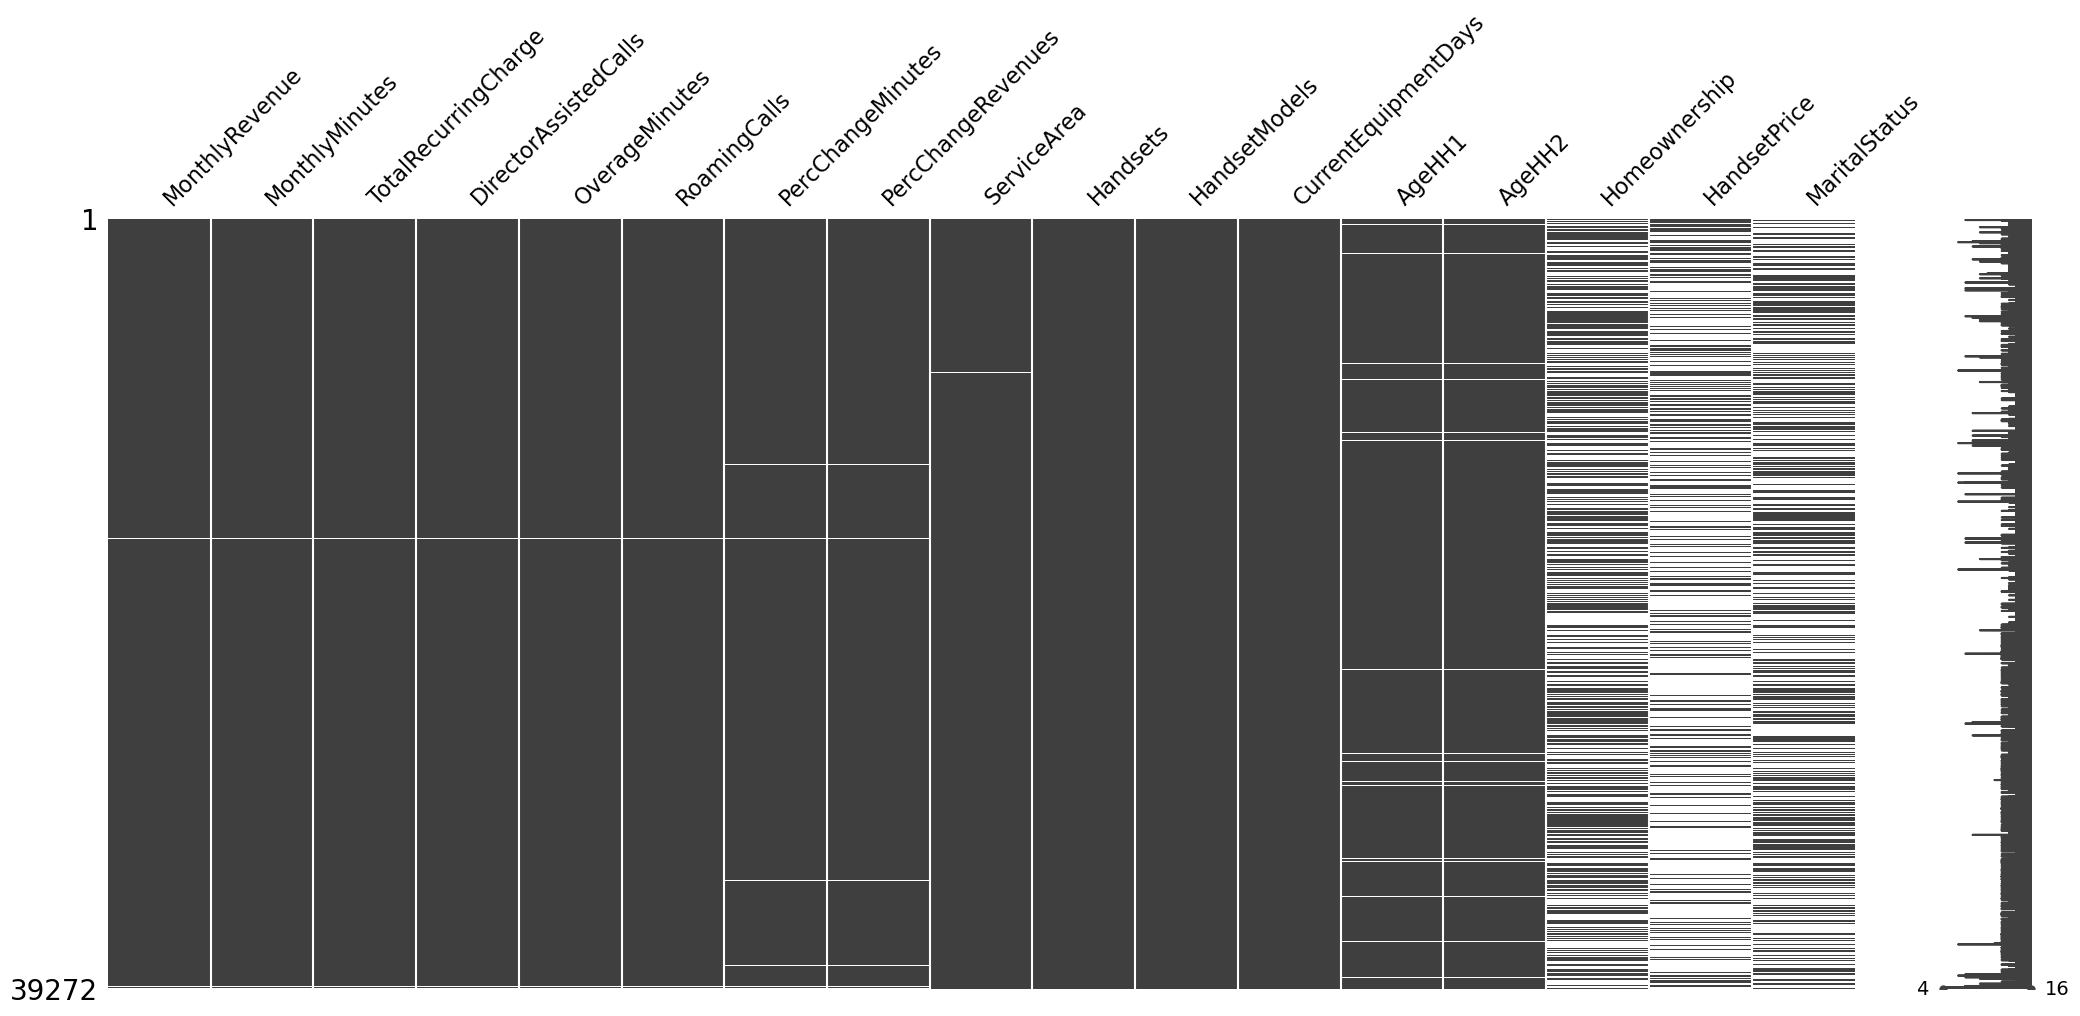

In [10]:
# null 데이터가 들어있는 비중 시각화
# 결측치가 없으면 색으로, 결측치가 있으면 흰색으로 시각화
viz_null = df[null_rows_selector][df_null.index]
msno.matrix(viz_null)

In [11]:
# 기존 데이터의 라벨과 null이 들어있는 데이터를 제외하고 나서의 라벨 구성 비율 비교
pd.concat([df.Churn.value_counts(normalize=True).rename("Overall"), df[null_rows_selector].Churn.value_counts(normalize=True).rename("within_null_rows")], axis=1)

,Overall,within_null_rows
No,0.711815,0.704039
Yes,0.288185,0.295961


In [12]:
contingency_table = pd.concat([df.Churn.value_counts().rename("Overall"), df[null_rows_selector].Churn.value_counts().rename("within_null_rows")], axis=1).transpose()
contingency_table

,No,Yes
Overall,36336,14711
within_null_rows,27649,11623


In [13]:
# 카이제곱 독립성 검정
# H0: 이탈여부의 분포는 널값의 여부와 상관관계가 없을 것이다.

stat, p, dof, expected = chi2_contingency(contingency_table.values)

# p-value 확인
alpha = 0.05 # 유의값 수준
print("p value is " + str(p))

print("Dependent (reject H0)") if p <= alpha else print("Independent (H0 holds true)")

p value is 0.011032150497537023
Dependent (reject H0)


## Null값의 존재는 통계적으로 이탈 여부에 중요한 영향을 미친다.
## 따라서 결측치를 또다른 특징으로 간주하고 결측치 제거 없이 훈련에 사용할 것임. 

In [14]:
def chi2test(X, y, alpha=0.05):
    # X: DataFrame
    # y: series
    
    target = y.name
    test_df = []
    for index, col in X.select_dtypes(include=['object']).columns.to_series().items():
        df = pd.concat([y, X[col]], axis=1)
        contingency_table = df.value_counts().rename('counts').reset_index().pivot(index=target, columns=col, values='counts').fillna(0)
        stat, p, dof, expected = chi2_contingency(contingency_table.values)
        test_df.append([target,col,stat,p,'Dependent (reject H0)' if p <= alpha else 'Independent (H0 holds true)','include' if p <= alpha else 'drop'])
        
    test_df = pd.DataFrame(test_df, columns=["variable1", "variable2", "chi2-stat", "p-value", "result", "recommendation"])
    return test_df

chi2test(df.drop('Churn', axis=1), df['Churn'])

,variable1,variable2,chi2-stat,p-value,result,recommendation
0,Churn,ServiceArea,959.134195,1.862609e-07,Dependent (reject H0),include
1,Churn,ChildrenInHH,4.618176,3.163486e-02,Dependent (reject H0),include
2,Churn,HandsetRefurbished,45.595205,1.453971e-11,Dependent (reject H0),include
3,Churn,HandsetWebCapable,196.373257,1.292123e-44,Dependent (reject H0),include
4,Churn,TruckOwner,1.157607,2.819623e-01,Independent (H0 holds true),drop
5,Churn,RVOwner,0.581561,4.457013e-01,Independent (H0 holds true),drop
6,Churn,Homeownership,0.000000,1.000000e+00,Independent (H0 holds true),drop
7,Churn,BuysViaMailOrder,23.993398,9.666660e-07,Dependent (reject H0),include
8,Churn,RespondsToMailOffers,26.688591,2.390287e-07,Dependent (reject H0),include
9,Churn,OptOutMailings,0.000000,1.000000e+00,Independent (H0 holds true),drop


In [15]:
## 'ServiceArea' 컬럼이 가장 상관관계가 높을 것으로 판단.
## 이산형 변수들의 카이제곱 검정 결과 파악 후, t-test 검정을 통해 컬럼마다 각 평균의 통계적으로 유의미한 차이가 있는지 확인

def t_test(X, y, alpha=0.05):
    target = y.name
    print('t_test with alpha', alpha)
    test_df = []
    for index, col in X.select_dtypes(exclude=['object']).columns.to_series().items():
        df = pd.concat([y, X[col]], axis=1)
        ttest_df = df.set_index(target, drop=True).fillna(0)
        # 비교하는 각각의 집단의 분산이 다르므로 Welch's t-검정을 실시할 것임.
        # Welch's t-test의 선행조건
        # 1. 자료는 모두 동일 간격을 가진 연속형 수치여야 한다
        # 2. 두 집단은 서로 독립적이어야한다
        # 3. 자료의 수치는 정규성을 가져야 한다.
        # 4. 두 집단 각각 추정된 분산이 다르다.
        stat, p = ttest_ind(ttest_df.loc["Yes"], ttest_df.loc["No"], equal_var=False) 
        test_df.append([target, col, stat, p, 'Dependent (reject H0)' if p <= alpha else 'Independent (H0 holds true)', 'include' if p <= alpha else 'drop'])
        
    test_df = pd.DataFrame(test_df, columns=['variable1', 'variable2', 't-test', 'p-value', 'result', 'recommendation'])
    return test_df

t_test(df.drop('Churn', axis=1), df['Churn'])

t_test with alpha 0.05


,variable1,variable2,t-test,p-value,result,recommendation
0,Churn,MonthlyRevenue,[-3.0178789820785163],[0.0025478602791834813],Dependent (reject H0),include
1,Churn,MonthlyMinutes,[-11.877849954853874],[1.835797057997502e-32],Dependent (reject H0),include
2,Churn,TotalRecurringCharge,[-14.52160176239891],[1.310521238648181e-47],Dependent (reject H0),include
3,Churn,DirectorAssistedCalls,[-4.8450245034580215],[1.2718380411479795e-06],Dependent (reject H0),include
4,Churn,OverageMinutes,[3.687404466662035],[0.00022697324858136802],Dependent (reject H0),include
5,Churn,RoamingCalls,[2.244494743224252],[0.024809892182594915],Dependent (reject H0),include
6,Churn,PercChangeMinutes,[-7.448350298200055],[9.747511469363198e-14],Dependent (reject H0),include
7,Churn,PercChangeRevenues,[2.282802936514573],[0.02245132129026347],Dependent (reject H0),include
8,Churn,DroppedCalls,[-3.5273600982343885],[0.000420395910890245],Dependent (reject H0),include
9,Churn,BlockedCalls,[-1.2668362619480196],[0.2052243596847742],Independent (H0 holds true),drop


## 최적화 모델 찾기

In [16]:
class Experiment:
    
    def __init__(self, model, data_transformer, pbounds=None):
        self.model = model
        self.data_transformer = data_transformer
        self.results = None
        self.pbounds = pbounds
        
    def evaluate(self, X, y):
        results = dict()
        predictions = self.model.predict(X)
        probas = self.model.predict_proba(X)
        results['report'] = metrics.classification_report(y, predictions, output_dict=True)
        results['roc'] = metrics.roc_auc_score(y, probas[:, 1])
        return results
    
    def hyper_parameter_tuning(self, X_train, y_train, X_val, y_val):
        
        def opt_function(**kwargs):
            current_params = dict()
            for key in self.pbounds:
                current_params[key] = int(kwargs[key])
            self.model.set_params(**current_params)
            self.model.fit(X_train, y_train)
            result = self.evaluate(X_val, y_val)
            return result['roc']
        
        optimizer = BayesianOptimization(
            f=opt_function,
            pbounds=self.pbounds,
            random_state=42,
            verbose=2
        )
        
        optimizer.maximize(
            init_points=10,
            n_iter=10,
        )
        
        params = optimizer.max['params']
        for key in params:
            params[key] = int(params[key])
        print('optimal target', optimizer.max['target'])
        print(params)
        
        return params
    
    def prep_data(self, df, target='Churn'):
        # stratify: 기존 데이터를 나눈 후, 클래스의 분포 비율도 근사시키려 시도해주는 파라미터
        X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target], test_size=0.2, random_state=42, stratify=df[target])
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)
        
        print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
        
        X_train, y_train = data_transformer.fit_transform(X_train, y_train)
        X_val, y_val = data_transformer.transform(X_val, y_val)
        X_test, y_test = data_transformer.transform(X_test, y_test)
        
        print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
        return X_train, y_train, X_val, y_val, X_test, y_test
    
    def __format_results__(self, results):
        r = pd.DataFrame(results)
        g = pd.concat([pd.DataFrame(x) for x in r.loc['report']])
        g.index = pd.MultiIndex.from_product([['train_data', 'val_data', 'test_data'], ['precision', 'recall', 'f1-score', 'support']],
                                            names=['dataset', 'metric'])
        return g.join(r.loc['roc'], on=['dataset'])
    
    def run(self, df, hptuning=False, **kwargs):
        
        X_train, y_train, X_val, y_val, X_test, y_test = self.prep_data(df)
        
        if hptuning:
            params = self.hyper_parameter_tuning(X_train, y_train, X_val, y_val)
            self.model = model.set_params(**params)
            
        %time self.model.fit(X_train, y_train, **kwargs)
        
        results = dict()
        results['train_data'] = self.evaluate(X_train, y_train)
        results['val_data'] = self.evaluate(X_val, y_val)
        results['test_data'] = self.evaluate(X_test, y_test)
        
        self.results = self.__format_results__(results)
        
        return self.results, X_train, y_train
    
    def test_evaluate(self, X):
        results = dict()
        predictions = self.model.predict(X)
        probas = self.model.predict_proba(X)
        
        return results, predictions, probas
    
    def test_run(self, df, hptuning=False, **kwargs):
        X_test = df
        X_test = data_transformer.test_transform(X_test)
        
        results = dict()
        results, predictions, probas = self.test_evaluate(X_test)
        
        return results, predictions, probas, X_test

In [17]:
class DataTransformer:
    
    def selectColumns(self, X, y):
        cols = []
        for func in [chi2test, t_test]:
            test_df = func(X, y)
            included_columns = test_df[test_df['recommendation'] == 'include']['variable2'].tolist()
            dropped_columns = test_df[test_df['recommendation'] == 'drop']['variable2'].tolist()
            
            print('dropped columns: ', dropped_columns, len(dropped_columns))
            cols.extend(included_columns)
            
        return cols
    
    def __init__(self, missingIndicator=False, featureSelection=False):
        
        self.featureSelection = featureSelection
        self.selectedColumns = None
        
        cont_imputer = SimpleImputer(strategy='mean')
        cont_normalizer = RobustScaler()
        cont_pipeline = make_pipeline(cont_imputer, cont_normalizer)
        
        if missingIndicator:
            cont_missing_indicator = MissingIndicator(features='all')
            cont_pipeline = make_union(cont_pipeline, cont_missing_indicator)
            
        cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
        # 시그마: 과적합을 줄이기 위한 수단, 표준 편차를 제공해 준다.
        cat_encoder = CE.leave_one_out.LeaveOneOutEncoder(sigma=0.05)
        cat_pipeline = make_pipeline(cat_imputer, cat_encoder)
        
        if missingIndicator:
            cat_missing_indicator = MissingIndicator(features='all')
            cat_pipeline = make_union(cat_pipeline, cat_missing_indicator)
            
        # 연속형 변수는 문자형 컬럼은 제외, 이산형 변수는 문자형 컬럼도 포함
        cont_selector = make_column_selector(dtype_exclude='object')
        cat_selector = make_column_selector(dtype_include='object')
        cont_cat_split_transform = make_column_transformer((cont_pipeline, cont_selector), (cat_pipeline, cat_selector), remainder='drop')
        xpipe = make_pipeline(cont_cat_split_transform)
        ypipe = LabelEncoder()
        
        self.X_pipeline = xpipe
        self.y_pipeline = ypipe
        
    def fit_transform(self, X, y):
        if self.featureSelection:
            self.selectedColumns = self.selectColumns(X, y)
            X = X[self.selectedColumns]
        y = self.y_pipeline.fit_transform(y)
        X = self.X_pipeline.fit_transform(X, y)
        
        return (X, y)
    
    def transform(self, X, y):
        y = self.y_pipeline.transform(y)
        if self.featureSelection:
            X = X[self.selectedColumns]
        X = self.X_pipeline.transform(X)
        
        return (X, y)
    
    def test_transform(self, X):
        if self.featureSelection:
            X = X[self.selectedColumns]
        X = self.X_pipeline.transform(X)
        
        return X

# 그래디언트 부스탕 모델과 랜덤포레스트 모델 비교
# sklearn.pipeline 사용해보기

In [18]:
%%time

data_transformer = DataTransformer(missingIndicator=True, featureSelection=True)
# 언더샘플링을 통한 데이터 불균형 조정
model = imblearn.pipeline.make_pipeline(RandomUnderSampler(random_state=42), GradientBoostingClassifier(random_state=42))
exp = Experiment(model, data_transformer, {"gradientboostingclassifier__max_depth":(3,20),"gradientboostingclassifier__max_features":(3,40),"gradientboostingclassifier__max_leaf_nodes":(32,128)})
results, X_train, y_train = exp.run(df, hptuning=True)

(30627, 56) (30627,) (10210, 56) (10210,) (10210, 56) (10210,)
dropped columns:  ['TruckOwner', 'RVOwner', 'Homeownership', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser', 'OwnsMotorcycle', 'Occupation', 'MaritalStatus'] 11
t_test with alpha 0.05
dropped columns:  ['PercChangeRevenues', 'DroppedCalls', 'BlockedCalls', 'DroppedBlockedCalls', 'CallForwardingCalls'] 5
(30627, 80) (30627,) (10210, 80) (10210,) (10210, 80) (10210,)
|   iter    |  target   | gradie... | gradie... | gradie... |
-------------------------------------------------------------
| 1         | 0.6679    | 9.367     | 38.18     | 102.3     |
| 2         | 0.6748    | 13.18     | 8.773     | 46.98     |
| 3         | 0.6697    | 3.987     | 35.05     | 89.71     |
| 4         | 0.6591    | 15.04     | 3.762     | 125.1     |
| 5         | 0.6737    | 17.15     | 10.86     | 49.46     |
| 6         | 0.6773    | 6.118     | 14.26     | 82.38     |
| 7         | 0.6719    | 10.34    

## Todo: 엑셀 등으로 통계적 검정 실시, submission 예측 및 파일 만들기

## Submission

In [19]:
df_test = df_test.drop('Churn', axis=1)
results, predictions, probas, X_test = exp.test_run(df_test, hptuning=True)

In [27]:
df_predictions = pd.DataFrame({'CustomerID': df_test.index, 'Churn_Predicted': predictions})
print(df_predictions[df_predictions['Churn_Predicted']==1].count())
print(df_predictions[df_predictions['Churn_Predicted']==0].count())

CustomerID         9074
Churn_Predicted    9074
dtype: int64
CustomerID         10926
Churn_Predicted    10926
dtype: int64
